In [11]:
import pandas as pd

# Load the CSV file
file_path = "insurance fraud claims.csv"   # <-- your file
df = pd.read_csv(file_path)

# Quick look at the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nColumn Info:\n")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())


Dataset Shape: (1000, 40)

First 5 rows:
    months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585       2014-10-17           OH   
1                 228   42         342868       2006-06-27           IN   
2                 134   29         687698       2000-09-06           OH   
3                 256   41         227811       1990-05-25           IL   
4                 228   44         367455       2014-06-06           IL   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500               1000                1406.91               0   
1    250/500               2000                1197.22         5000000   
2    100/300               2000                1413.14         5000000   
3    250/500               2000                1415.74         6000000   
4   500/1000               1000                1583.91         6000000   

   insured_zip  ... police_report_available total_claim_amount

In [12]:
# Drop empty column
df = df.drop(columns=['_c39'])

# Convert dates to datetime
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'], errors='coerce')
df['incident_date'] = pd.to_datetime(df['incident_date'], errors='coerce')

# Replace "?" with NaN in all object columns
df = df.replace("?", np.nan)

# Check missing values again
print("Missing Values After Cleaning:\n", df.isnull().sum())


Missing Values After Cleaning:
 months_as_customer               0
age                              0
policy_number                    0
policy_bind_date                 0
policy_state                     0
policy_csl                       0
policy_deductable                0
policy_annual_premium            0
umbrella_limit                   0
insured_zip                      0
insured_sex                      0
insured_education_level          0
insured_occupation               0
insured_hobbies                  0
insured_relationship             0
capital-gains                    0
capital-loss                     0
incident_date                    0
incident_type                    0
collision_type                 178
incident_severity                0
authorities_contacted           91
incident_state                   0
incident_city                    0
incident_location                0
incident_hour_of_the_day         0
number_of_vehicles_involved      0
property_damage        

In [13]:
# Step 1: Drop high-cardinality ID-like columns
df = df.drop(columns=['policy_number', 'insured_zip', 'incident_location'])

# Step 2: Fill missing categorical values with "Unknown"
for col in ['collision_type', 'authorities_contacted', 'property_damage', 'police_report_available']:
    df[col] = df[col].fillna("Unknown")

# Step 3: Encode target column (fraud_reported: Y=1, N=0)
df['fraud_reported'] = df['fraud_reported'].map({'Y': 1, 'N': 0})

# Step 4: Verify
print(df[['collision_type','authorities_contacted','property_damage','police_report_available']].head(10))
print("\nFraud Reported Value Counts:\n", df['fraud_reported'].value_counts())


    collision_type authorities_contacted property_damage  \
0   Side Collision                Police             YES   
1          Unknown                Police         Unknown   
2   Rear Collision                Police              NO   
3  Front Collision                Police         Unknown   
4          Unknown               Unknown              NO   
5   Rear Collision                  Fire              NO   
6  Front Collision                Police         Unknown   
7  Front Collision                Police         Unknown   
8  Front Collision                Police              NO   
9   Rear Collision                 Other              NO   

  police_report_available  
0                     YES  
1                 Unknown  
2                      NO  
3                      NO  
4                      NO  
5                      NO  
6                 Unknown  
7                     YES  
8                     YES  
9                 Unknown  

Fraud Reported Value Counts:
 

In [14]:
from sklearn.preprocessing import OneHotEncoder

# Step 1: Identify categorical columns (object type, except target column)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('fraud_reported')  # target column is already numeric

print("Categorical Columns:", categorical_cols)

# Step 2: One-Hot Encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 3: Verify
print("Shape before encoding:", df.shape)
print("Shape after encoding:", df_encoded.shape)
print("\nColumns after encoding:\n", df_encoded.columns[:20])  # show first 20 columns


ValueError: list.remove(x): x not in list

In [15]:
# Step 1: Identify categorical columns (object type only)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_cols)

# Step 2: One-Hot Encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 3: Verify
print("Shape before encoding:", df.shape)
print("Shape after encoding:", df_encoded.shape)
print("\nColumns after encoding (first 20):\n", df_encoded.columns[:20])


Categorical Columns: ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'property_damage', 'police_report_available', 'auto_make', 'auto_model']
Shape before encoding: (1000, 36)
Shape after encoding: (1000, 147)

Columns after encoding (first 20):
 Index(['months_as_customer', 'age', 'policy_bind_date', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'capital-gains',
       'capital-loss', 'incident_date', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year', 'fraud_reported', 'policy_state_IN'],
      dtype='object')


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Step 1: Separate features (X) and target (y)
X = df_encoded.drop(columns=['fraud_reported'])
y = df_encoded['fraud_reported']

# Step 2: Train/Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Train Logistic Regression
log_reg = LogisticRegression(max_iter=500, solver='liblinear')
log_reg.fit(X_train, y_train)

# Step 4: Predictions
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:,1]

# Step 5: Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>)

In [17]:
# Drop raw datetime columns if still present
if 'policy_bind_date' in df_encoded.columns:
    df_encoded = df_encoded.drop(columns=['policy_bind_date'])
if 'incident_date' in df_encoded.columns:
    df_encoded = df_encoded.drop(columns=['incident_date'])

print("Final shape after dropping datetime columns:", df_encoded.shape)


Final shape after dropping datetime columns: (1000, 145)


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Features and target
X = df_encoded.drop(columns=['fraud_reported'])
y = df_encoded['fraud_reported']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=500, solver='liblinear')
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:,1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))


Confusion Matrix:
 [[150   1]
 [ 49   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.99      0.86       151
           1       0.00      0.00      0.00        49

    accuracy                           0.75       200
   macro avg       0.38      0.50      0.43       200
weighted avg       0.57      0.75      0.65       200

ROC-AUC Score: 0.6030544668198405


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train Random Forest with class_weight='balanced' to handle imbalance
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:,1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_rf))


Confusion Matrix:
 [[141  10]
 [ 44   5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.93      0.84       151
           1       0.33      0.10      0.16        49

    accuracy                           0.73       200
   macro avg       0.55      0.52      0.50       200
weighted avg       0.66      0.73      0.67       200

ROC-AUC Score: 0.8205162859845925


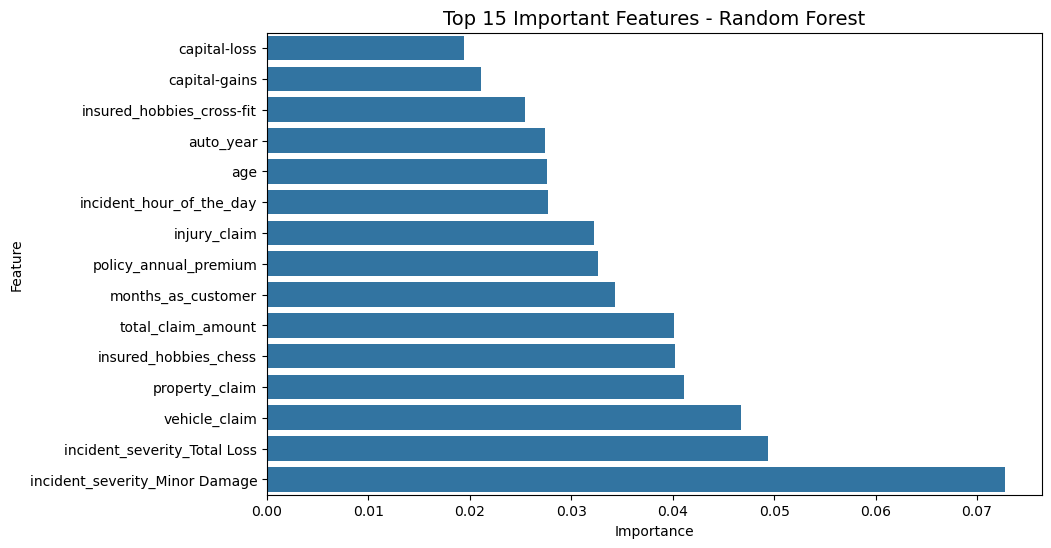

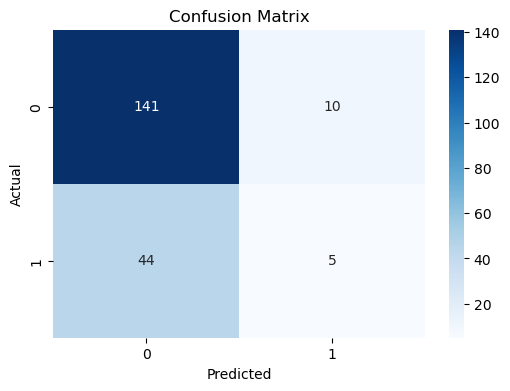

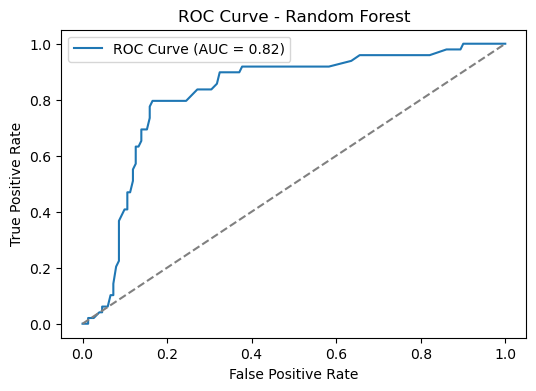

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

# --- Feature Importance ---
importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title("Top 15 Important Features - Random Forest", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# --- Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rf)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_pred_prob_rf):.2f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


C:\Users\Suman Singh\AppData\Local\Temp\ipykernel_28824\799127655.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="fraud_reported", data=df, palette="coolwarm")


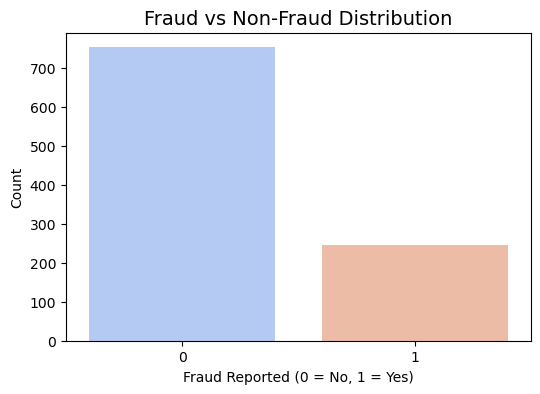

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(x="fraud_reported", data=df, palette="coolwarm")
plt.title("Fraud vs Non-Fraud Distribution", fontsize=14)
plt.xlabel("Fraud Reported (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


C:\Users\Suman Singh\AppData\Local\Temp\ipykernel_28824\4130732469.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fraud_reported", y="total_claim_amount", data=df, palette="Set2")


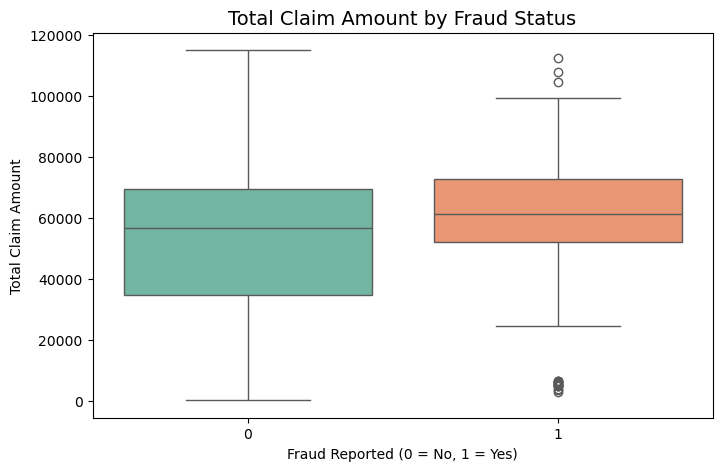

In [24]:
plt.figure(figsize=(8,5))
sns.boxplot(x="fraud_reported", y="total_claim_amount", data=df, palette="Set2")
plt.title("Total Claim Amount by Fraud Status", fontsize=14)
plt.xlabel("Fraud Reported (0 = No, 1 = Yes)")
plt.ylabel("Total Claim Amount")
plt.show()


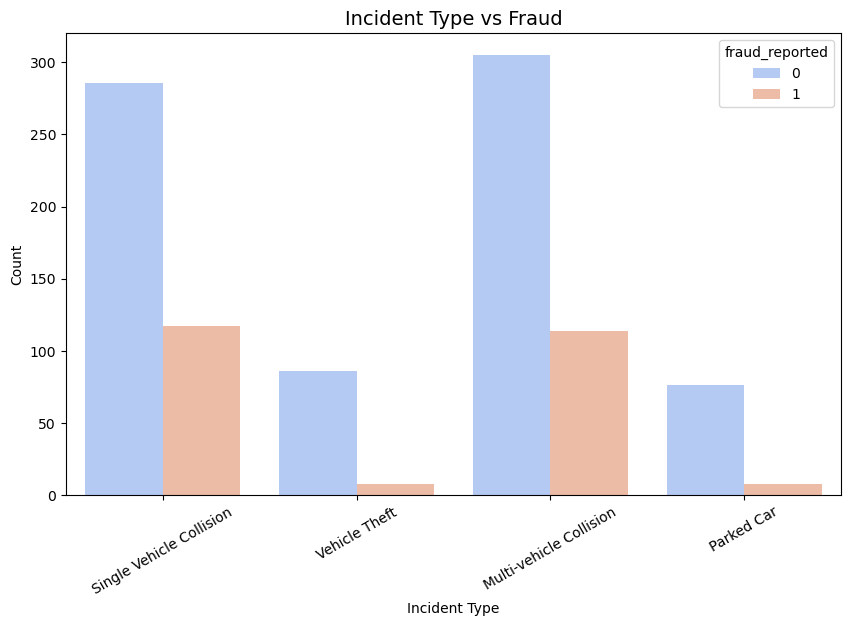

In [25]:
plt.figure(figsize=(10,6))
sns.countplot(x="incident_type", hue="fraud_reported", data=df, palette="coolwarm")
plt.title("Incident Type vs Fraud", fontsize=14)
plt.xlabel("Incident Type")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()


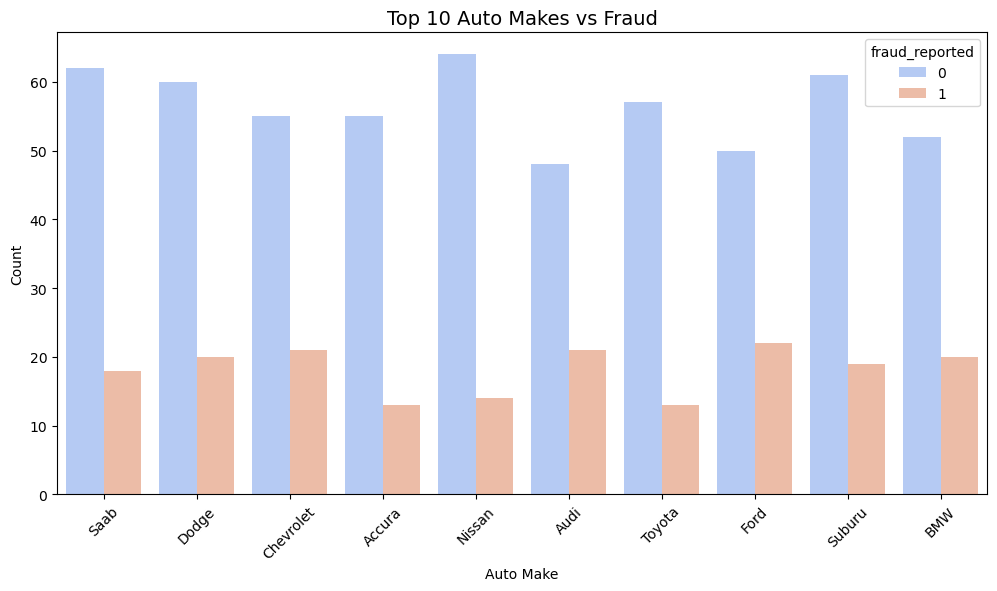

In [26]:
plt.figure(figsize=(12,6))
top_makes = df['auto_make'].value_counts().nlargest(10).index
sns.countplot(x="auto_make", hue="fraud_reported", data=df[df['auto_make'].isin(top_makes)], palette="coolwarm")
plt.title("Top 10 Auto Makes vs Fraud", fontsize=14)
plt.xlabel("Auto Make")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


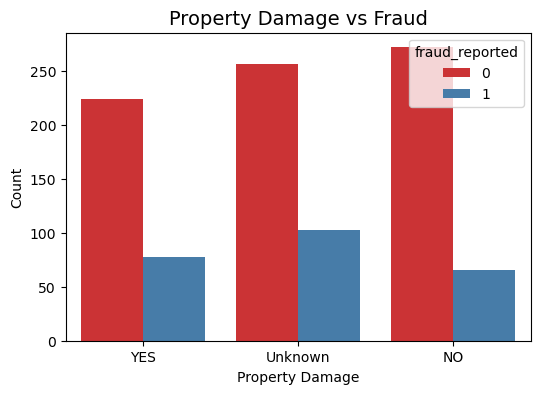

In [27]:
plt.figure(figsize=(6,4))
sns.countplot(x="property_damage", hue="fraud_reported", data=df, palette="Set1")
plt.title("Property Damage vs Fraud", fontsize=14)
plt.xlabel("Property Damage")
plt.ylabel("Count")
plt.show()


In [28]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Step 1: Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

# Step 2: Train Random Forest on balanced data
rf_smote = RandomForestClassifier(n_estimators=200, random_state=42)
rf_smote.fit(X_train_res, y_train_res)

# Step 3: Predictions
y_pred_smote = rf_smote.predict(X_test)
y_pred_prob_smote = rf_smote.predict_proba(X_test)[:,1]

# Step 4: Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_smote))


Before SMOTE: fraud_reported
0    602
1    198
Name: count, dtype: int64
After SMOTE: fraud_reported
0    602
1    602
Name: count, dtype: int64
Confusion Matrix:
 [[139  12]
 [ 36  13]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       151
           1       0.52      0.27      0.35        49

    accuracy                           0.76       200
   macro avg       0.66      0.59      0.60       200
weighted avg       0.73      0.76      0.73       200

ROC-AUC Score: 0.7707798351128531


In [29]:
def fraud_monitoring(transaction, model, threshold=0.5):
    """
    Simulates real-time fraud detection.
    transaction: a single row (Pandas DataFrame)
    model: trained ML model
    threshold: fraud probability cutoff
    """
    prob = model.predict_proba(transaction)[0][1]
    if prob >= threshold:
        return f"⚠️ ALERT: Fraud risk {prob:.2f} → Review Needed"
    else:
        return f"✅ Legitimate Transaction (fraud risk {prob:.2f})"

# Example: Test on 5 random transactions
sample_transactions = X_test.sample(5, random_state=42)
for i, row in sample_transactions.iterrows():
    result = fraud_monitoring(row.to_frame().T, rf_smote, threshold=0.5)
    print(f"Transaction {i}: {result}")


Transaction 498: ✅ Legitimate Transaction (fraud risk 0.46)
Transaction 758: ✅ Legitimate Transaction (fraud risk 0.28)
Transaction 8: ✅ Legitimate Transaction (fraud risk 0.17)
Transaction 130: ✅ Legitimate Transaction (fraud risk 0.24)
Transaction 528: ✅ Legitimate Transaction (fraud risk 0.24)


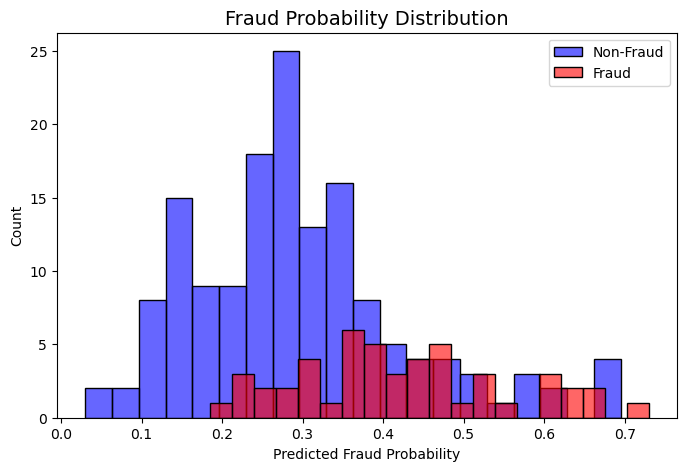

In [30]:
plt.figure(figsize=(8,5))
sns.histplot(y_pred_prob_smote[y_test==0], color="blue", label="Non-Fraud", bins=20, alpha=0.6)
sns.histplot(y_pred_prob_smote[y_test==1], color="red", label="Fraud", bins=20, alpha=0.6)
plt.title("Fraud Probability Distribution", fontsize=14)
plt.xlabel("Predicted Fraud Probability")
plt.ylabel("Count")
plt.legend()
plt.show()


C:\Users\Suman Singh\AppData\Local\Temp\ipykernel_28824\1945432084.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


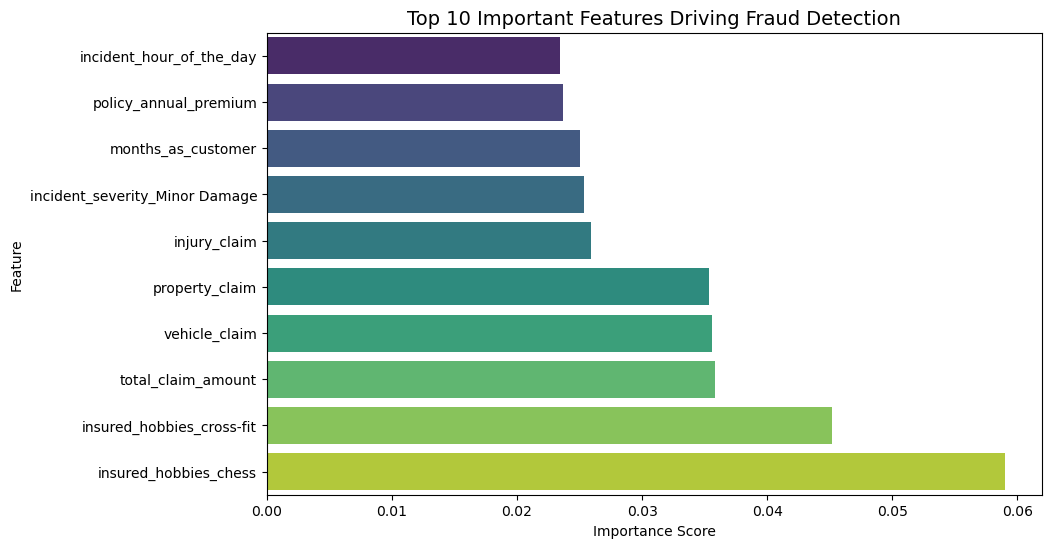

In [31]:
# Get top 10 important features
importances = rf_smote.feature_importances_
indices = np.argsort(importances)[-10:]
top_features = X_train.columns[indices]
top_importances = importances[indices]

plt.figure(figsize=(10,6))
sns.barplot(x=top_importances, y=top_features, palette="viridis")
plt.title("Top 10 Important Features Driving Fraud Detection", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()
